## Download and Prepare Data

#### Import Libraries

In [ ]:
import os
from sklearn.model_selection import train_test_split as tts
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten , AveragePooling2D
from keras.utils import np_utils
from random import randint
import numpy as np
import os
from PIL import Image
import glob, os
import xgboost as xgb
#sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
#load package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from math import sqrt
import seaborn as sns
import numpy
import warnings
from keras.optimizers import RMSprop
warnings.filterwarnings('ignore')

#### Download Data

In [ ]:
!mkdir data

In [ ]:
cd data

/content/data


In [ ]:
#'cow',"lobster","panda"
classes = ["bear", "bird", "dog","camel", "dolphin","snake","snail","swan","zebra",'cat',"giraffe","octopus", "fish"]

In [ ]:
for c in classes:
  if c+'.npy' not in glob.glob("*.npy"):
    os.system('wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%c)

In [ ]:
!ls

bear.npy   cat.npy	fish.npy     snail.npy	zebra.npy
bird.npy   dog.npy	giraffe.npy  snake.npy
camel.npy  dolphin.npy	octopus.npy  swan.npy


#### Load Data

In [ ]:
# create lists for data files and objects in the same order
os.chdir('/content/data')
files=[]
objects=[]
for file in glob.glob("*.npy"):
  if file.split('.')[0] in classes:
    objects.append(file.split('.')[0])
    files.append(file)
print(objects)
print(files)

['bear', 'swan', 'giraffe', 'dog', 'octopus', 'cat', 'camel', 'fish', 'zebra', 'bird', 'snake', 'dolphin', 'snail']
['bear.npy', 'swan.npy', 'giraffe.npy', 'dog.npy', 'octopus.npy', 'cat.npy', 'camel.npy', 'fish.npy', 'zebra.npy', 'bird.npy', 'snake.npy', 'dolphin.npy', 'snail.npy']


In [ ]:
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)

{0: 'bear', 1: 'swan', 2: 'giraffe', 3: 'dog', 4: 'octopus', 5: 'cat', 6: 'camel', 7: 'fish', 8: 'zebra', 9: 'bird', 10: 'snake', 11: 'dolphin', 12: 'snail'}


In [ ]:
N = 20000 # samples for each class

In [ ]:
d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


In [ ]:
print( 'Total number of samples: ', len(d_x))

Total number of samples:  260000


#### Visualize Data

In [ ]:
Image.fromarray(np.reshape(d_x[1000], (28,28)))

#### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255
d_y = to_categorical(d_y,13)

In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (260000, 784)
Shape of y:  (260000, 13)


## Comparison of ML Algorithms 

##### define functions

In [ ]:
def initializeMLA():
  MLA = [
      #Ensemble Methods
      ensemble.AdaBoostClassifier(),
      ensemble.BaggingClassifier(),
      ensemble.GradientBoostingClassifier(),
      ensemble.RandomForestClassifier(max_depth=3),
      XGBClassifier(),
      
      #GLM
      linear_model.LogisticRegressionCV(),
      
      #Navies Ba## Comparison of ML Algorithms 
      naive_bayes.BernoulliNB(),
      naive_bayes.GaussianNB(),
      
      #Nearest Neighbor
      neighbors.KNeighborsClassifier(),
      
      #SVM
      svm.SVC(probability=True),
      #Trees    
      tree.DecisionTreeClassifier(max_depth=3),
      ]
  return MLA

In [ ]:
def train_MLA_return_result(MLA):
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
      print(alg)
      MLA_name = alg.__class__.__name__
      alg.fit(numpy.array(x_train), numpy.array(y_train))
      predicted = alg.predict(x_test)
      #fp, tp, th = roc_curve(y_test, predicted, average='micro')
      
      MLA_compare.loc[row_index,'MLA Name'] = MLA_name
      MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(x_train, y_train), 4)
      MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(x_test, y_test), 4)
      MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(y_test, predicted, average='macro')
      MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(y_test, predicted, average='macro')
      #MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)

      row_index+=1
  MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
  return MLA_compare

In [ ]:
def plot_MLA(MLA_compare):
  plt.subplots(figsize=(15,6))
  sns.barplot(x="MLA Name", y="MLA Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
  plt.xticks(rotation=90)
  plt.title('MLA Train Accuracy Comparison')
  plt.show()

### 1st Scenario (3 classes ,500 sample)

Test size = 0.2 , number of classes = 3 , number of samples = 500 for each clas

#### Load & Prepare Data

##### Load

In [ ]:
files = ['bear.npy', 'giraffe.npy', 'octopus.npy']
objects = ['bear', 'giraffe', 'octopus']
for c in objects:
  if c+'.npy' not in glob.glob("*.npy"):
    os.system('wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%c)

In [ ]:
# try ML algortihms with 3 classes
files=files[0:3]
objects=objects[0:3]
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)
N_Drawings=len(objects)

d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<500:
      c+=1
      d_x.append(j)
      d_y.append(i)


{0: 'bear', 1: 'giraffe', 2: 'octopus'}


##### Normalizing Features

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (1500, 784)
Shape of y:  (1500,)


##### Prepare Training and Test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

#### Train ML Models

In [ ]:
MLA = initializeMLA()
MLA_compare = train_MLA_return_result(MLA)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
           

#### Results

In [ ]:
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall
9,SVC,0.9875,0.9067,0.908013,0.906667
4,XGBClassifier,0.9958,0.8833,0.883360,0.883333
8,KNeighborsClassifier,0.9292,0.8800,0.887400,0.880000
2,GradientBoostingClassifier,1.0000,0.8733,0.873186,0.873333
5,LogisticRegressionCV,0.9067,0.8500,0.851216,0.850000
6,BernoulliNB,0.8525,0.8267,0.834069,0.826667
0,AdaBoostClassifier,0.9175,0.8100,0.812600,0.810000
1,BaggingClassifier,0.9967,0.8067,0.807604,0.806667
3,RandomForestClassifier,0.8817,0.8067,0.809914,0.806667
7,GaussianNB,0.7383,0.7133,0.767412,0.713333


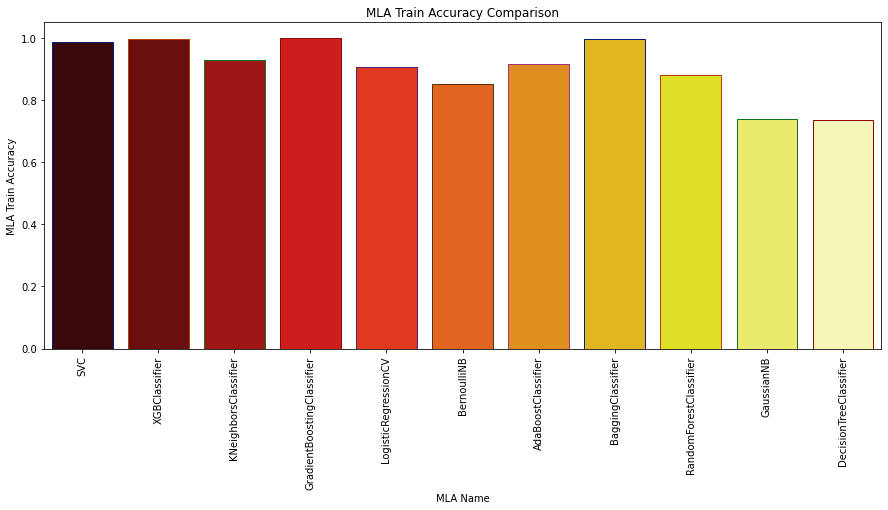

In [ ]:
plot_MLA(MLA_compare)

In [ ]:
print('Number of data in training :', len(x_train))
print('Number of data in test :', len(x_test))

Number of data in training : 1200
Number of data in test : 300


### 2nd Scenario (3 classes, 1000 sample)

In [ ]:
N = 1000 # Number of samples

#### Load & Prepare Data

##### Load

In [ ]:
files = ['bear.npy', 'giraffe.npy', 'octopus.npy']
objects = ['bear', 'giraffe', 'octopus']
for c in objects:
  if c+'.npy' not in glob.glob("*.npy"):
    os.system('wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%c)

In [ ]:
# try ML algortihms with 3 classes
files=files[0:3]
objects=objects[0:3]
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)
N_Drawings=len(objects)

d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


{0: 'bear', 1: 'giraffe', 2: 'octopus'}


##### Normalizing Features

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (1500, 784)
Shape of y:  (1500,)


##### Prepare Training and Test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

#### Train ML Models

In [ ]:
MLA = initializeMLA()
MLA_compare = train_MLA_return_result(MLA)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
           

#### Results

In [ ]:
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall
9,SVC,0.9817,0.9183,0.919741,0.918333
2,GradientBoostingClassifier,0.9946,0.9050,0.906602,0.905000
4,XGBClassifier,0.9846,0.9050,0.906297,0.905000
8,KNeighborsClassifier,0.9392,0.9033,0.905208,0.903333
5,LogisticRegressionCV,0.9204,0.8500,0.850251,0.850000
1,BaggingClassifier,0.9958,0.8333,0.837245,0.833333
3,RandomForestClassifier,0.8550,0.8283,0.830594,0.828333
6,BernoulliNB,0.8550,0.8167,0.820045,0.816667
0,AdaBoostClassifier,0.8796,0.8067,0.807494,0.806667
7,GaussianNB,0.7467,0.7250,0.761934,0.725000


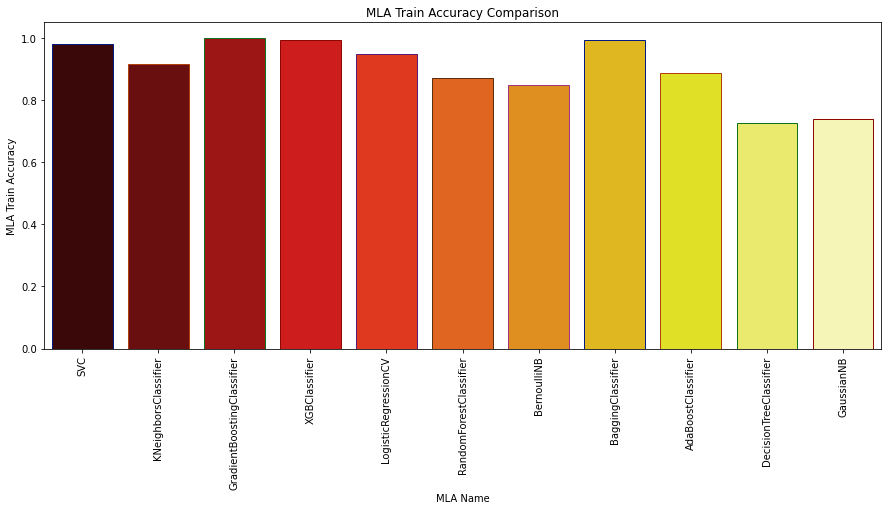

In [ ]:
plot_MLA(MLA_compare)

In [ ]:
print('Number of data in training :', len(x_train))
print('Number of data in test :', len(x_test))

Number of data in training : 1200
Number of data in test : 300


### Parameter Tuning for knn and SVC

#### knn

In [ ]:
param_grid = [{'n_neighbors': [3, 5, 10,15,20,30] }]
grid_search_knn = GridSearchCV(neighbors.KNeighborsClassifier(), param_grid, cv=5, verbose=3)
grid_search_knn.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=3, score=0.892, total=   0.3s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.871, total=   0.3s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.879, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.896, total=   0.3s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.908, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.900, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.908, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.863, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.912, total=   0.3s
[CV] n_neighbors=5 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   10.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 5, 10, 15, 20, 30]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid_search_knn.best_params_

{'n_neighbors': 5}

In [ ]:
grid_search_knn.best_score_

0.8975

In [ ]:
grid_predictions = grid_search_knn.best_estimator_.predict(x_test) 

In [ ]:
round(grid_search_knn.best_estimator_.score(x_test,y_test) , 4)

0.88

In [ ]:
knn_tuned = grid_search_knn.best_estimator_

In [ ]:
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86       100
         1.0       0.81      0.96      0.88       100
         2.0       0.91      0.89      0.90       100

    accuracy                           0.88       300
   macro avg       0.89      0.88      0.88       300
weighted avg       0.89      0.88      0.88       300



#### SVC

In [ ]:
param_grid = {'C': [0.1, 1, 10],  
              'gamma': ['scale', 1, 0.1, 0.01], 
              'kernel': ['rbf']}  
  
grid_search_svc = GridSearchCV(svm.SVC(probability=True), param_grid, refit = True, verbose = 3) 
grid_search_svc.fit(x_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
grid_search_svc.best_params_

In [ ]:
grid_search_svc.best_score_

In [ ]:
grid_predictions = grid_search_svc.predict(x_test) 

In [ ]:
svc_tuned = grid_search_svc.best_estimator_

In [ ]:
svc_tuned

In [ ]:
print(classification_report(y_test, grid_predictions)) 

### Ensemble Learning (Soft Voting)

Replace knn and svc with their fine-tuned versions

In [ ]:
for n, i in enumerate(MLA):
  if i.__class__.__name__ == 'KNeighborsClassifier':
    MLA[n] = knn_tuned
 # elif i.__class__.__name__ == 'SVC':
   # MLA[n] = svc_tuned

Get the best performing 5 models

In [ ]:
best5 = MLA_compare.index[0:5]

Combine them using soft voting

In [ ]:
voting_clf = VotingClassifier(estimators = [('1',MLA[best5[0]]),
                                            ('2',MLA[best5[1]]),
                                            ('3',MLA[best5[2]]),
                                            ('4',MLA[best5[3]]),
                                            ('5',MLA[best5[4]])], 
                              voting = 'soft') 
voting_clf.fit(x_train,y_train)
y_pred = voting_clf.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       100
         1.0       0.89      0.93      0.91       100
         2.0       0.89      0.91      0.90       100

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



### 3rd Scenario (13 classes, 500 sample)

In [ ]:
N = 500 # Number of samples

#### Load & Prepare Data

##### Load

In [ ]:
#'cow',"lobster","panda"
classes = ["bear", "bird", "dog","camel", "dolphin","snake","snail","swan","zebra",'cat',"giraffe","octopus", "fish"]

In [ ]:
# create lists for data files and objects in the same order
os.chdir('/content/data')
files=[]
objects=[]
for file in glob.glob("*.npy"):
  if file.split('.')[0] in classes:
    objects.append(file.split('.')[0])
    files.append(file)
print(objects)
print(files)

['giraffe', 'dog', 'bear', 'cat', 'octopus', 'fish', 'dolphin', 'snake', 'swan', 'snail', 'camel', 'bird', 'zebra']
['giraffe.npy', 'dog.npy', 'bear.npy', 'cat.npy', 'octopus.npy', 'fish.npy', 'dolphin.npy', 'snake.npy', 'swan.npy', 'snail.npy', 'camel.npy', 'bird.npy', 'zebra.npy']


In [ ]:
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)
N_Drawings=len(objects)

d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


{0: 'giraffe', 1: 'dog', 2: 'bear', 3: 'cat', 4: 'octopus', 5: 'fish', 6: 'dolphin', 7: 'snake', 8: 'swan', 9: 'snail', 10: 'camel', 11: 'bird', 12: 'zebra'}


##### Normalizing Features

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (6500, 784)
Shape of y:  (6500,)


##### Prepare Training and Test data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

#### Train ML Models

In [ ]:
MLA = initializeMLA()
MLA_compare = train_MLA_return_result(MLA)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
           

#### Results

In [ ]:
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall
9,SVC,0.8738,0.6331,0.627202,0.633077
8,KNeighborsClassifier,0.7067,0.5900,0.603588,0.590000
4,XGBClassifier,0.8352,0.5685,0.552950,0.568462
2,GradientBoostingClassifier,0.9363,0.5654,0.552431,0.565385
5,LogisticRegressionCV,0.5935,0.5454,0.531705,0.545385
6,BernoulliNB,0.4787,0.4992,0.488227,0.499231
1,BaggingClassifier,0.9958,0.4685,0.467290,0.468462
3,RandomForestClassifier,0.4179,0.3969,0.358504,0.396923
0,AdaBoostClassifier,0.3813,0.3923,0.374835,0.392308
7,GaussianNB,0.2460,0.2462,0.432418,0.246154


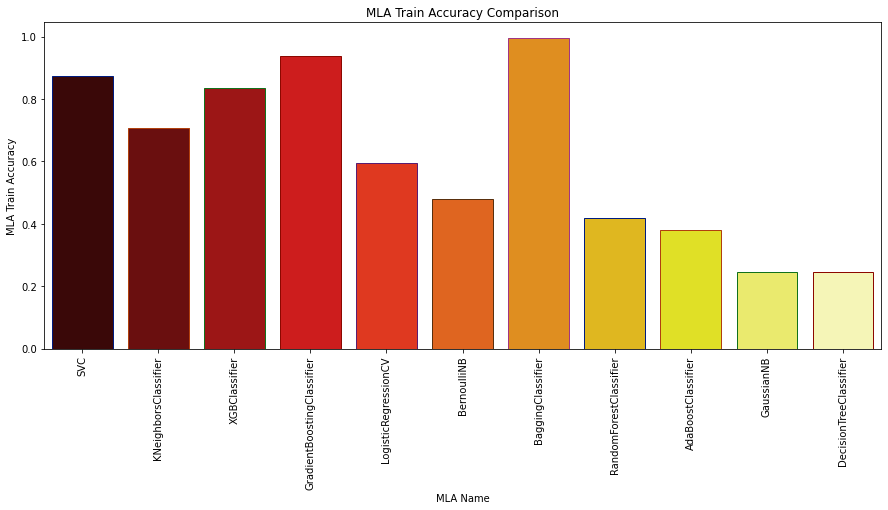

In [ ]:
plot_MLA(MLA_compare)

## CNN (lenet-5)

### Explanation of Lenet

LeNet-5 CNN architecture is made up of 7 layers. The layer composition consists of 3 convolutional layers, 2 subsampling layers and 2 fully connected layers. Original paper can be found in http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

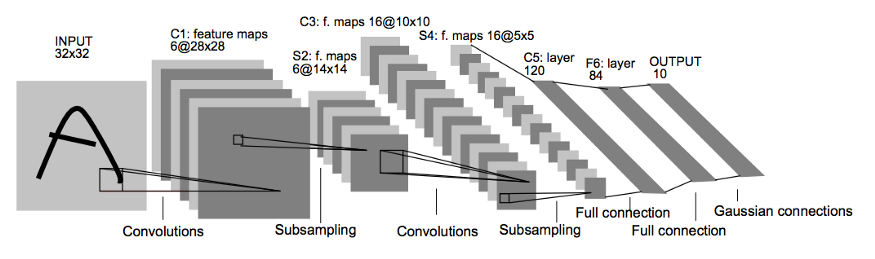

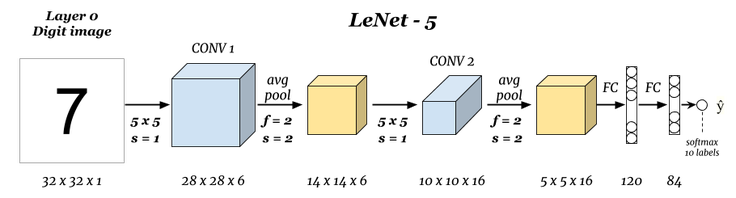

"The first layer is the input layer — this is generally not considered a layer of the network as nothing is learnt in this layer. The input layer is built to take in 32x32, and these are the dimensions of images that are passed into the next layer. Those who are familiar with the MNIST dataset will be aware that the MNIST dataset images have the dimensions 28x28. To get the MNIST images dimension to the meet the requirements of the input layer, the 28x28 images are padded." Taken from
https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

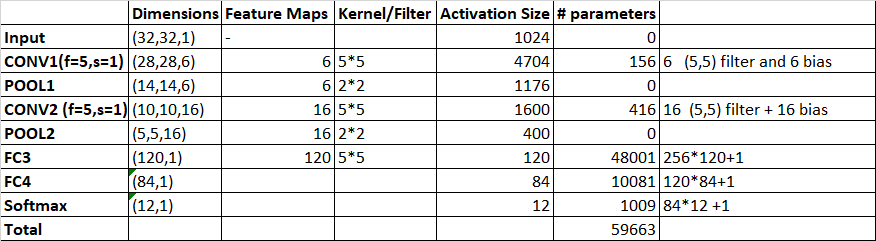

The dimensions and the number of parameters can be seen in the table above. In total there are **59663** paremeters to learn

### Define Functions

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping



es = EarlyStopping(monitor='val_loss', patience=5, \
                   verbose=1, mode='min', restore_best_weights=True)



In [ ]:
# A function to fit CNN models to train data and print the observed result on test data
def compile_train_result(model):
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  # train
  model.fit(np.array(x_train), np.array(y_train), batch_size=256, validation_split=0.2,epochs=N_EPOCHS,callbacks=[es],verbose=1)
  
  best_epoch = np.argmin(model.history.history['val_loss'])+1
  
  model = lenet5_v2_initialize()
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  model.fit(np.array(x_train), np.array(y_train), batch_size=256 ,epochs=best_epoch,verbose=1)

  print ("Training complete")

  print ("Evaluating model")
  preds = model.predict(np.array(x_test))

  score = 0
  for i in range(len(preds)):
      if np.argmax(preds[i]) == y_test[i]:
          score += 1

  print("Test Accuracy: ", ((score + 0.0) / len(preds)) * 100)
def lenet5_v2_initialize():
  lenet5_v2 = Sequential()
  lenet5_v2.add(Conv2D(128, kernel_size=5, strides=1,  activation='relu', input_shape=(28,28,1), padding='same'))# C1
  lenet5_v2.add(MaxPooling2D(pool_size=(2, 2)))
  lenet5_v2.add(Conv2D(16, kernel_size=5, strides=1, activation='relu', padding='valid'))
  lenet5_v2.add(MaxPooling2D(pool_size=(2, 2)))
  lenet5_v2.add(Dropout(0.25))
  lenet5_v2.add(Flatten())
  lenet5_v2.add(Dense(120, activation='relu'))
  lenet5_v2.add(Dropout(0.2))
  lenet5_v2.add(Dense(84, activation='relu'))
  lenet5_v2.add(Dense(N_Drawings, activation='softmax'))
  return lenet5_v2

### 3 classes 500 sample

In [ ]:
N = 500 # samples for each class


#### Load & Prepare Data

##### Load

In [ ]:
files = ['bear.npy', 'giraffe.npy', 'octopus.npy']
objects = ['bear', 'giraffe', 'octopus']
for c in objects:
  if c+'.npy' not in glob.glob("*.npy"):
    os.system('wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%c)

In [ ]:
# try ML algortihms with 3 classes
files=files[0:3]
objects=objects[0:3]
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)
N_Drawings=len(objects)

d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


{0: 'bear', 1: 'giraffe', 2: 'octopus'}


##### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (1500, 784)
Shape of y:  (1500,)


##### Adjust Shape

In [ ]:
d_x=d_x.reshape(-1,28,28,1)

##### Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

In [ ]:
y_train = np_utils.to_categorical(y_train, N_Drawings)
Y_test = np_utils.to_categorical(y_test, N_Drawings)

In [ ]:
x_train.shape

(1200, 28, 28, 1)

#### Train Model

In [ ]:
N_EPOCHS = 50
N_Drawings = 3

In [ ]:
lenet5 = lenet5_v2_initialize()

In [ ]:
compile_train_result(lenet5)

Epoch 1/50
4/4 [==============================] - 1s 77ms/step - loss: 1.0942 - accuracy: 0.3635 - val_loss: 1.0397 - val_accuracy: 0.3958
Epoch 2/50
4/4 [==============================] - 0s 29ms/step - loss: 1.0038 - accuracy: 0.5473 - val_loss: 0.7891 - val_accuracy: 0.8000
Epoch 3/50
4/4 [==============================] - 0s 30ms/step - loss: 0.7895 - accuracy: 0.6892 - val_loss: 0.5666 - val_accuracy: 0.7958
Epoch 4/50
4/4 [==============================] - 0s 27ms/step - loss: 0.6347 - accuracy: 0.7290 - val_loss: 0.4678 - val_accuracy: 0.8208
Epoch 5/50
4/4 [==============================] - 0s 29ms/step - loss: 0.4668 - accuracy: 0.8270 - val_loss: 0.4063 - val_accuracy: 0.8417
Epoch 6/50
4/4 [==============================] - 0s 28ms/step - loss: 0.4233 - accuracy: 0.8415 - val_loss: 0.3398 - val_accuracy: 0.8833
Epoch 7/50
4/4 [==============================] - 0s 27ms/step - loss: 0.3690 - accuracy: 0.8706 - val_loss: 0.3340 - val_accuracy: 0.9000
Epoch 8/50
4/4 [===========

### 13 classes 500 sample

In [ ]:
N = 500 # samples for each class

#### Load & Prepare Data

##### Load

In [ ]:
#'cow',"lobster","panda"
classes = ["bear", "bird", "dog","camel", "dolphin","snake","snail","swan","zebra",'cat',"giraffe","octopus", "fish"]

In [ ]:
# create lists for data files and objects in the same order
os.chdir('/content/data')
files=[]
objects=[]
for file in glob.glob("*.npy"):
  if file.split('.')[0] in classes:
    objects.append(file.split('.')[0])
    files.append(file)
print(objects)
print(files)

['bear', 'swan', 'giraffe', 'dog', 'octopus', 'cat', 'camel', 'fish', 'zebra', 'bird', 'snake', 'dolphin', 'snail']
['bear.npy', 'swan.npy', 'giraffe.npy', 'dog.npy', 'octopus.npy', 'cat.npy', 'camel.npy', 'fish.npy', 'zebra.npy', 'bird.npy', 'snake.npy', 'dolphin.npy', 'snail.npy']


In [ ]:
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)

{0: 'bear', 1: 'swan', 2: 'giraffe', 3: 'dog', 4: 'octopus', 5: 'cat', 6: 'camel', 7: 'fish', 8: 'zebra', 9: 'bird', 10: 'snake', 11: 'dolphin', 12: 'snail'}


In [ ]:
d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


In [ ]:
print( 'Total number of samples: ', len(d_x))

Total number of samples:  6500


##### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (6500, 784)
Shape of y:  (6500,)


##### Adjust Shape

In [ ]:
d_x=d_x.reshape(-1,28,28,1)

##### Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

In [ ]:
y_train = np_utils.to_categorical(y_train, 13)
Y_test = np_utils.to_categorical(y_test, 13)

In [ ]:
x_train.shape

(5200, 28, 28, 1)

#### Train Model

In [ ]:
N_EPOCHS = 50
N_Drawings = 13

In [ ]:
lenet5 = lenet5_v2_initialize()

In [ ]:
compile_train_result(lenet5)

Epoch 1/50
17/17 [==============================] - 1s 30ms/step - loss: 2.5371 - accuracy: 0.1094 - val_loss: 2.2686 - val_accuracy: 0.2846
Epoch 2/50
17/17 [==============================] - 0s 16ms/step - loss: 2.2623 - accuracy: 0.2382 - val_loss: 1.9487 - val_accuracy: 0.3942
Epoch 3/50
17/17 [==============================] - 0s 16ms/step - loss: 1.9868 - accuracy: 0.3652 - val_loss: 1.7370 - val_accuracy: 0.4663
Epoch 4/50
17/17 [==============================] - 0s 16ms/step - loss: 1.7763 - accuracy: 0.4272 - val_loss: 1.5597 - val_accuracy: 0.5067
Epoch 5/50
17/17 [==============================] - 0s 16ms/step - loss: 1.6035 - accuracy: 0.4868 - val_loss: 1.4688 - val_accuracy: 0.5269
Epoch 6/50
17/17 [==============================] - 0s 16ms/step - loss: 1.5234 - accuracy: 0.5126 - val_loss: 1.3659 - val_accuracy: 0.5596
Epoch 7/50
17/17 [==============================] - 0s 16ms/step - loss: 1.4069 - accuracy: 0.5654 - val_loss: 1.2881 - val_accuracy: 0.5846
Epoch 8/50
17

### 13 classes 1000 sample

In [ ]:
N = 1000 # samples for each class

#### Load & Prepare Data

##### Load

In [ ]:
#'cow',"lobster","panda"
classes = ["bear", "bird", "dog","camel", "dolphin","snake","snail","swan","zebra",'cat',"giraffe","octopus", "fish"]

In [ ]:
# create lists for data files and objects in the same order
os.chdir('/content/data')
files=[]
objects=[]
for file in glob.glob("*.npy"):
  if file.split('.')[0] in classes:
    objects.append(file.split('.')[0])
    files.append(file)
print(objects)
print(files)

['bear', 'swan', 'giraffe', 'dog', 'octopus', 'cat', 'camel', 'fish', 'zebra', 'bird', 'snake', 'dolphin', 'snail']
['bear.npy', 'swan.npy', 'giraffe.npy', 'dog.npy', 'octopus.npy', 'cat.npy', 'camel.npy', 'fish.npy', 'zebra.npy', 'bird.npy', 'snake.npy', 'dolphin.npy', 'snail.npy']


In [ ]:
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)

{0: 'bear', 1: 'swan', 2: 'giraffe', 3: 'dog', 4: 'octopus', 5: 'cat', 6: 'camel', 7: 'fish', 8: 'zebra', 9: 'bird', 10: 'snake', 11: 'dolphin', 12: 'snail'}


In [ ]:
d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


In [ ]:
print( 'Total number of samples: ', len(d_x))

Total number of samples:  13000


##### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (13000, 784)
Shape of y:  (13000,)


##### Adjust Shape

In [ ]:
d_x=d_x.reshape(-1,28,28,1)

##### Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

In [ ]:
y_train = np_utils.to_categorical(y_train, 13)
Y_test = np_utils.to_categorical(y_test, 13)

In [ ]:
x_train.shape

(10400, 28, 28, 1)

#### Train Model

In [ ]:
N_EPOCHS = 100
N_Drawings = 13

In [ ]:
lenet5 = lenet5_v2_initialize()

In [ ]:
compile_train_result(lenet5)

Epoch 1/100
33/33 [==============================] - 1s 22ms/step - loss: 2.5049 - accuracy: 0.1263 - val_loss: 1.8929 - val_accuracy: 0.4409
Epoch 2/100
33/33 [==============================] - 1s 16ms/step - loss: 1.9135 - accuracy: 0.3822 - val_loss: 1.4319 - val_accuracy: 0.5625
Epoch 3/100
33/33 [==============================] - 1s 16ms/step - loss: 1.5194 - accuracy: 0.5047 - val_loss: 1.1998 - val_accuracy: 0.6361
Epoch 4/100
33/33 [==============================] - 1s 16ms/step - loss: 1.3314 - accuracy: 0.5809 - val_loss: 1.0672 - val_accuracy: 0.6740
Epoch 5/100
33/33 [==============================] - 1s 16ms/step - loss: 1.1764 - accuracy: 0.6271 - val_loss: 0.9757 - val_accuracy: 0.7120
Epoch 6/100
33/33 [==============================] - 1s 16ms/step - loss: 1.1252 - accuracy: 0.6509 - val_loss: 0.9181 - val_accuracy: 0.7269
Epoch 7/100
33/33 [==============================] - 1s 16ms/step - loss: 1.0084 - accuracy: 0.6795 - val_loss: 0.8938 - val_accuracy: 0.7255
Epoch 

### 13 classes 20000 sample

In [ ]:
N = 20000 # samples for each class

#### Load & Prepare Data

##### Load

In [ ]:
#'cow',"lobster","panda"
classes = ["bear", "bird", "dog","camel", "dolphin","snake","snail","swan","zebra",'cat',"giraffe","octopus", "fish"]

In [ ]:
# create lists for data files and objects in the same order
os.chdir('/content/data')
files=[]
objects=[]
for file in glob.glob("*.npy"):
  if file.split('.')[0] in classes:
    objects.append(file.split('.')[0])
    files.append(file)
print(objects)
print(files)

['bear', 'swan', 'giraffe', 'dog', 'octopus', 'cat', 'camel', 'fish', 'zebra', 'bird', 'snake', 'dolphin', 'snail']
['bear.npy', 'swan.npy', 'giraffe.npy', 'dog.npy', 'octopus.npy', 'cat.npy', 'camel.npy', 'fish.npy', 'zebra.npy', 'bird.npy', 'snake.npy', 'dolphin.npy', 'snail.npy']


In [ ]:
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)

{0: 'bear', 1: 'swan', 2: 'giraffe', 3: 'dog', 4: 'octopus', 5: 'cat', 6: 'camel', 7: 'fish', 8: 'zebra', 9: 'bird', 10: 'snake', 11: 'dolphin', 12: 'snail'}


In [ ]:
d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


In [ ]:
print( 'Total number of samples: ', len(d_x))

Total number of samples:  260000


##### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255


In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (260000, 784)
Shape of y:  (260000,)


##### Adjust Shape

In [ ]:
d_x=d_x.reshape(-1,28,28,1)

##### Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

In [ ]:
y_train = np_utils.to_categorical(y_train, 13)
Y_test = np_utils.to_categorical(y_test, 13)

In [ ]:
x_train.shape

(208000, 28, 28, 1)

#### Train Model & Result

In [ ]:
N_EPOCHS = 100
N_Drawings = 13

In [ ]:
lenet5 = lenet5_v2_initialize()

In [ ]:
compile_train_result(lenet5)

Epoch 1/100
650/650 [==============================] - 10s 15ms/step - loss: 1.5293 - accuracy: 0.5051 - val_loss: 0.7507 - val_accuracy: 0.7678
Epoch 2/100
650/650 [==============================] - 9s 14ms/step - loss: 0.8357 - accuracy: 0.7391 - val_loss: 0.6262 - val_accuracy: 0.8042
Epoch 3/100
650/650 [==============================] - 9s 14ms/step - loss: 0.7223 - accuracy: 0.7736 - val_loss: 0.5678 - val_accuracy: 0.8206
Epoch 4/100
650/650 [==============================] - 9s 14ms/step - loss: 0.6628 - accuracy: 0.7919 - val_loss: 0.5482 - val_accuracy: 0.8272
Epoch 5/100
650/650 [==============================] - 9s 14ms/step - loss: 0.6321 - accuracy: 0.8009 - val_loss: 0.5156 - val_accuracy: 0.8362
Epoch 6/100
650/650 [==============================] - 9s 14ms/step - loss: 0.6090 - accuracy: 0.8068 - val_loss: 0.5063 - val_accuracy: 0.8388
Epoch 7/100
650/650 [==============================] - 9s 14ms/step - loss: 0.5815 - accuracy: 0.8162 - val_loss: 0.4901 - val_accuracy

## TRANSFER LEARNING

### 3 Classes

In [ ]:
N = 20000

#### Load & Prepare Data

In [ ]:
files = ['bear.npy', 'giraffe.npy', 'octopus.npy']
objects = ['bear', 'giraffe', 'octopus']
for c in objects:
  if c+'.npy' not in glob.glob("*.npy"):
    os.system('wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%c)

In [ ]:
# try ML algortihms with 3 classes
files=files[0:3]
objects=objects[0:3]
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)
N_Drawings=len(objects)

d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


{0: 'bear', 1: 'giraffe', 2: 'octopus'}


##### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255
d_y = to_categorical(d_y,3)

In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (60000, 784)
Shape of y:  (60000, 3)


#### Prepare Training and Test data for RESNET

*  Convert 1 channel to 3 channel for Resnet
*  by copying same data to all 3 channels
*  We padded zeros to all images, 2 times to match the desired input shape of RESNET (1,32,32,3)

##### Adjust Shape

In [ ]:
d_x=d_x.reshape(-1,28,28,1)
d_x = np.repeat(d_x, 3, -1)
d_x = np.pad(d_x, ((0,0),(2,2),(2,2),(0,0)), 'constant')

##### Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

In [ ]:
x_train.shape

(48000, 32, 32, 3)

#### RESNET

In [ ]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

In [ ]:
model_r = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
keras_input = Input(shape= (32, 32, 3), name = 'image_input')
output_r_conv = model_r(keras_input)

My_r = Flatten(name='flatten')(output_r_conv)
My_r = Dense(1024, activation='relu', name='fc1')(My_r)
My_r = Dense(128, activation='relu', name='fc2')(My_r)
My_r = Dense(N_Drawings, activation='softmax', name='predictions')(My_r)
pretrained_model = Model(inputs=keras_input, outputs=My_r)

from keras.optimizers import Adam
pretrained_model.compile(Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', patience=3, \
                   verbose=1, mode='min', restore_best_weights=True)

pretrained_model.fit(x_train, y_train, validation_split=0.2 ,batch_size=128,\
             epochs=1000, callbacks=[es],verbose=1)

Epoch 1/1000
300/300 [==============================] - 26s 72ms/step - loss: 0.5893 - accuracy: 0.7500 - val_loss: 3.5377 - val_accuracy: 0.3315
Epoch 2/1000
300/300 [==============================] - 21s 71ms/step - loss: 0.2673 - accuracy: 0.8903 - val_loss: 2.0284 - val_accuracy: 0.3427
Epoch 3/1000
300/300 [==============================] - 21s 70ms/step - loss: 0.1948 - accuracy: 0.9216 - val_loss: 0.7497 - val_accuracy: 0.7066
Epoch 4/1000
300/300 [==============================] - 21s 69ms/step - loss: 0.1440 - accuracy: 0.9429 - val_loss: 0.4451 - val_accuracy: 0.8454
Epoch 5/1000
300/300 [==============================] - 21s 69ms/step - loss: 0.1096 - accuracy: 0.9589 - val_loss: 0.3862 - val_accuracy: 0.8766
Epoch 6/1000
300/300 [==============================] - 21s 70ms/step - loss: 0.0886 - accuracy: 0.9662 - val_loss: 0.3679 - val_accuracy: 0.8799
Epoch 7/1000
300/300 [==============================] - 21s 70ms/step - loss: 0.0728 - accuracy: 0.9726 - val_loss: 0.4210 -

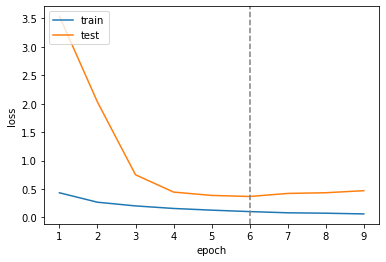

In [ ]:
import matplotlib.pyplot as plt
best_epoch = np.argmin(pretrained_model.history.history['val_loss'])+1
epoch_len = len(pretrained_model.history.history['loss'])

plt.plot(list(range(1,epoch_len+1)),pretrained_model.history.history['loss']) 
plt.plot(list(range(1,epoch_len+1)),pretrained_model.history.history['val_loss']) 
plt.axvline(x=best_epoch,linestyle='--',color='grey')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_r = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
keras_input = Input(shape= (32, 32, 3), name = 'image_input')
output_r_conv = model_r(keras_input)

My_r = Flatten(name='flatten')(output_r_conv)
My_r = Dense(1024, activation='relu', name='fc1')(My_r)
My_r = Dense(128, activation='relu', name='fc2')(My_r)
My_r = Dense(N_Drawings, activation='softmax', name='predictions')(My_r)
pretrained_model = Model(inputs=keras_input, outputs=My_r)

from keras.optimizers import Adam
pretrained_model.compile(Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

pretrained_model.fit(x_train, y_train, batch_size=128, epochs=best_epoch,verbose=1)

Epoch 1/6
375/375 [==============================] - 29s 66ms/step - loss: 0.5637 - accuracy: 0.7671
Epoch 2/6
375/375 [==============================] - 25s 67ms/step - loss: 0.2616 - accuracy: 0.8970
Epoch 3/6
375/375 [==============================] - 25s 65ms/step - loss: 0.1994 - accuracy: 0.9215
Epoch 4/6
375/375 [==============================] - 24s 65ms/step - loss: 0.1577 - accuracy: 0.9367
Epoch 5/6
375/375 [==============================] - 25s 66ms/step - loss: 0.1227 - accuracy: 0.9519
Epoch 6/6
375/375 [==============================] - 25s 66ms/step - loss: 0.0980 - accuracy: 0.9625


In [ ]:
accuracy_train = pretrained_model.evaluate(x=x_train, y=y_train, batch_size=128,verbose=0)
print("Train Accuracy: ", round(accuracy_train[1]*100,4) ,'%')

accuracy_test = pretrained_model.evaluate(x=x_test, y=y_test, batch_size=128,verbose=0)
print("Test Accuracy: ", round(accuracy_test[1]*100,4), '%')

Train Accuracy:  97.6854 %
Test Accuracy:  89.2083 %


### 13 Classes

#### Load & Prepare Data

In [ ]:
N = 20000

##### Load

In [ ]:
#'cow',"lobster","panda"
classes = ["bear", "bird", "dog","camel", "dolphin","snake","snail","swan","zebra",'cat',"giraffe","octopus", "fish"]

In [ ]:
# create lists for data files and objects in the same order
os.chdir('/content/data')
files=[]
objects=[]
for file in glob.glob("*.npy"):
  if file.split('.')[0] in classes:
    objects.append(file.split('.')[0])
    files.append(file)
print(objects)
print(files)

['giraffe', 'dog', 'bear', 'cat', 'octopus', 'fish', 'dolphin', 'snake', 'swan', 'snail', 'camel', 'bird', 'zebra']
['giraffe.npy', 'dog.npy', 'bear.npy', 'cat.npy', 'octopus.npy', 'fish.npy', 'dolphin.npy', 'snake.npy', 'swan.npy', 'snail.npy', 'camel.npy', 'bird.npy', 'zebra.npy']


In [ ]:
enum=enumerate(objects)
DRAWINGS=dict((i,j) for i,j in enum)
print(DRAWINGS)

{0: 'giraffe', 1: 'dog', 2: 'bear', 3: 'cat', 4: 'octopus', 5: 'fish', 6: 'dolphin', 7: 'snake', 8: 'swan', 9: 'snail', 10: 'camel', 11: 'bird', 12: 'zebra'}


In [ ]:
d_x = []
d_y = []

for i in range(len(files)): 
  d = np.load('/content/data/'+files[i])
  c = 0
  for j in d:
    if c<N:
      c+=1
      d_x.append(j)
      d_y.append(i)


In [ ]:
print( 'Total number of samples: ', len(d_x))

Total number of samples:  260000


##### Prepare Data

**Preparing the Data**
*   Normalized data by dividig it each pixel value by 255
*   We dont have any missing data
*   Applied one hot encoding for target labels(y_train, y_test) 

##### Normalizing Features & One Hot Encoding of Labels

In [ ]:
from keras.utils import to_categorical

d_x = np.array(d_x).astype('float32')
d_y = np.array(d_y).astype('float32')

d_x = d_x/255
d_y = to_categorical(d_y,13)

In [ ]:
print('Shape of X: ', d_x.shape)
print('Shape of y: ', d_y.shape)

Shape of X:  (260000, 784)
Shape of y:  (260000, 13)


#### Prepare Training and Test data for RESNET

*  Convert 1 channel to 3 channel for Resnet
*  by copying same data to all 3 channels
*  We padded zeros to all images, 2 times to match the desired input shape of RESNET (1,32,32,3)

##### Adjust Shape

In [ ]:
d_x=d_x.reshape(-1,28,28,1)
d_x = np.repeat(d_x, 3, -1)
d_x = np.pad(d_x, ((0,0),(2,2),(2,2),(0,0)), 'constant')

##### Train test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(d_x, d_y,stratify=d_y, test_size=0.2)

In [ ]:
x_train.shape

(208000, 32, 32, 3)

#### RESNET Training

In [ ]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense
from keras.models import Model, load_model

In [ ]:
model_r = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
keras_input = Input(shape= (32, 32, 3), name = 'image_input')
output_r_conv = model_r(keras_input)

My_r = Flatten(name='flatten')(output_r_conv)
My_r = Dense(1024, activation='relu', name='fc1')(My_r)
My_r = Dense(128, activation='relu', name='fc2')(My_r)
My_r = Dense(13, activation='softmax', name='predictions')(My_r)
pretrained_model = Model(inputs=keras_input, outputs=My_r)

from keras.optimizers import Adam
pretrained_model.compile(Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

pretrained_model.fit(x_train, y_train,batch_size=128,epochs=4,verbose=1)

Epoch 1/4
1625/1625 [==============================] - 105s 62ms/step - loss: 0.9987 - accuracy: 0.6925
Epoch 2/4
1625/1625 [==============================] - 104s 64ms/step - loss: 0.4350 - accuracy: 0.8619
Epoch 3/4
1625/1625 [==============================] - 106s 65ms/step - loss: 0.3621 - accuracy: 0.8830
Epoch 4/4
1625/1625 [==============================] - 107s 66ms/step - loss: 0.3058 - accuracy: 0.9005


In [ ]:
accuracy_train = pretrained_model.evaluate(x=x_train, y=y_train, batch_size=128,verbose=0)
print("Train Accuracy: ", round(accuracy_train[1]*100,4) ,'%')

accuracy_test = pretrained_model.evaluate(x=x_test, y=y_test, batch_size=128,verbose=0)
print("Test Accuracy: ", round(accuracy_test[1]*100,4), '%')

Train Accuracy:  92.2962 %
Test Accuracy:  87.0904 %


## Getting Input from User for RESNET

In [ ]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from PIL import Image 
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=200, h=200, line_width=3):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

def get_drawing():
  draw()
  img = Image.open('drawing.png')
  arr = np.array(img.getchannel(3)) # It has 4 channels since it is not a RGB image we are just taking the alpha channel
  img2 = Image.fromarray(arr) # create image with 1 channel
  img_32x32 = np.array(img2.resize((32, 32), Image.ANTIALIAS)) # resize image to 28,28)
  img_array = (img_32x32.flatten())
  img_array  = img_array.reshape(-1,1).T 
  img_array = img_array.astype('float32')/255 # normalize the values
  array = np.reshape(img_array, (1,32,32,1))
  array = np.repeat(array, 3, -1)
  return array

def predict_drawing(model,array):
  print("Predicted as : ", DRAWINGS[np.argmax(model.predict(drawing),axis=1)[0]])

In [ ]:
drawing = get_drawing()

In [ ]:
predict_drawing(pretrained_model,drawing)

Predicted as :  bear


In [ ]:
DRAWINGS

{0: 'giraffe',
 1: 'dog',
 2: 'bear',
 3: 'cat',
 4: 'octopus',
 5: 'fish',
 6: 'dolphin',
 7: 'snake',
 8: 'swan',
 9: 'snail',
 10: 'camel',
 11: 'bird',
 12: 'zebra'}

## OTHER STUFF

### Trying with photos

In [ ]:
%cd ..

/content


In [ ]:
img = Image.open('/content/depositphotos_73192567-stock-illustration-dolphin-doodle.jpg')
ary = np.array(img)

# Split the three channels
r,g,b = np.split(ary,3,axis=2)
r=r.reshape(-1)
g=r.reshape(-1)
b=r.reshape(-1)

# Standard RGB to grayscale 
bitmap = list(map(lambda x: 0.299*x[0]+0.587*x[1]+0.114*x[2], 
zip(r,g,b)))
bitmap = np.array(bitmap).reshape([ary.shape[0], ary.shape[1]])
bitmap = np.dot((bitmap > 128).astype(float),255)
im = Image.fromarray(bitmap.astype(np.uint8))
img_28x28 = np.array(im.resize((28, 28), Image.ANTIALIAS)) # resize image to 28,28)
img_array = (img_28x28.flatten())
img_array  = img_array.reshape(-1,1).T 
img_array = img_array.astype('float32')/255 # normalize the values
array = np.reshape(img_array, (1,28,28,1)) 

### Save model for android

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp4c00y2nl/assets
